### <a href="https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/all.zip">Dataset</a>

### Load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import time
import xgboost as xgb
from preprocess import clahe, sectioning, sectioning_img, hist_equalization
from unused import sectioning_, display_sections
from feature_extraction import extract_features, convert_to_feature_vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
sys.path.append('../')
from load_images import load

In [2]:
img_size = (512, 512)
X, y, masks = load(img_size)

In [3]:
X_unseen, y_unseen = X[:5], y[:5]
X, y = X[5:], y[5:]

CLAHE operation will be performed on images before sectioning.

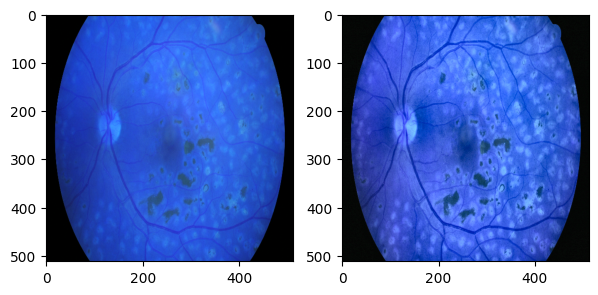

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(7,4))
ax[0].imshow(X[1], cmap='gray')
ax[1].imshow(clahe(X[1]), cmap='gray')
plt.show()

### Divide image into NxN sections

In [5]:
n = 5
num_img = 15
sections, targets = sectioning(X, y, num_img, img_size, n)

### Convert sections to feature vectors

In [6]:
section_features = convert_to_feature_vec(sections)
X_train, X_test, y_train, y_test = train_test_split(section_features, targets, test_size=0.2, shuffle=True)

### Train XGBoost Classifier

In [7]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Evaluate performance on unseen image

In [8]:
j = np.random.randint(0,5)
sections = sectioning_img(X_unseen[j], n)
X_new = np.zeros((sections.shape[0], 13))

for i in range(sections.shape[0]):
    X_new[i] = extract_features(sections[i])

y_new = y_unseen[j].flatten()
_, y_new = cv2.threshold(y_new, 128, 1, cv2.THRESH_BINARY)

Train set: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98   2962370
           1       0.63      0.86      0.73    183358

    accuracy                           0.96   3145728
   macro avg       0.81      0.91      0.85   3145728
weighted avg       0.97      0.96      0.97   3145728

------------------------------------------------------

Test set: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    740460
           1       0.63      0.84      0.72     45972

    accuracy                           0.96    786432
   macro avg       0.81      0.91      0.85    786432
weighted avg       0.97      0.96      0.96    786432

------------------------------------------------------

Unseen image: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    242561
           1       0.71      0.70      0.70     19583

    accuracy                  

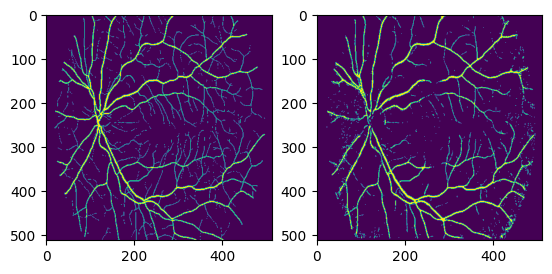

In [9]:
y_pred_train = xgb_clf.predict(X_train)
y_pred_test = xgb_clf.predict(X_test)
y_pred_new = xgb_clf.predict(X_new)

print(f'Train set: \n {classification_report(y_pred_train, y_train)}')
print('------------------------------------------------------\n')
print(f'Test set: \n {classification_report(y_pred_test, y_test)}')
print('------------------------------------------------------\n')
print(f'Unseen image: \n{classification_report(y_pred_new, y_new)}')

y_new = y_new.reshape(img_size)
y_pred_new = y_pred_new.reshape(img_size)
fig,ax = plt.subplots(1,2)
ax[0].imshow(y_new)
ax[1].imshow(y_pred_new)
plt.show()

### Performance on 5 unseen images

In [10]:
X5, y5 = sectioning(X_unseen, y_unseen, 5, img_size, n, [_ for _ in range(5)])

In [11]:
X5 = convert_to_feature_vec(X5)

In [12]:
y5_pred = xgb_clf.predict(X5)
print(classification_report(y5_pred, y5))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98   1220569
           1       0.67      0.70      0.68     90151

    accuracy                           0.96   1310720
   macro avg       0.82      0.84      0.83   1310720
weighted avg       0.96      0.96      0.96   1310720

